In [18]:
import numpy as np
import pandas as pd
import sklearn as skl

from datetime import datetime
from matplotlib import pyplot

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.externals.joblib import dump
from sklearn.externals.joblib import load


### 1a) Load training and testing dataset

In [19]:
startTimeScript = datetime.now()

file_path_train = 'aps_failure_training_set.csv'
df_train = pd.read_csv(file_path_train, na_values="na")

file_path_test = 'aps_failure_test_set.csv'
df_test = pd.read_csv(file_path_test, na_values="na")

df_train.tail()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
59995,neg,153002,NaN,6.640000e+02,186.0,0.0,0.0,0.0,0.0,0.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,neg,2286,NaN,2.130707e+09,224.0,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
59997,neg,112,0.0,2.130706e+09,18.0,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
59998,neg,80292,NaN,2.130706e+09,494.0,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0
59999,neg,40222,NaN,6.980000e+02,628.0,0.0,0.0,0.0,0.0,0.0,...,440066.0,183200.0,344546.0,254068.0,225148.0,158304.0,170384.0,158.0,0.0,0.0


### 1b) Sanity check and convert a string to binary value

    * There would be only two classes (neg and pos) so we will treat it as binary classification task which means we gonna another column to convert string class to binary values; neg to 0 and pos to 1

In [20]:
df_train['targetVar'] = 1
df_train['targetVar'] = np.where(df_train['class']=='neg', 0, df_train['targetVar'])
df_train.drop('class', axis=1, inplace=True)

df_test['targetVar'] = 1
df_test['targetVar'] = np.where(df_test['class']=='neg', 0, df_test['targetVar'])
df_test.drop('class', axis=1, inplace=True)

df_train = df_train.rename(columns={'class': 'targetVar'})
df_test = df_test.rename(columns={'class': 'targetVar'})

In [21]:
df_train.head(20)

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,targetVar
0,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,0.0,...,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0,0
1,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0,0
2,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0,0
3,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,318.0,...,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0,0
4,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,0.0,...,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0,0
5,38312,NaN,2.130706e+09,218.0,0.0,0.0,0.0,0.0,0.0,0.0,...,288278.0,900430.0,300412.0,1534.0,338.0,856.0,0.0,0.0,0.0,0
6,14,0.0,6.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,60.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,102960,NaN,2.130706e+09,116.0,0.0,0.0,0.0,0.0,0.0,0.0,...,384948.0,915978.0,1052166.0,1108672.0,341532.0,129504.0,7832.0,0.0,0.0,0
8,78696,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,362510.0,1190028.0,1012704.0,160090.0,63216.0,41202.0,4.0,0.0,0.0,0
9,153204,0.0,1.820000e+02,NaN,0.0,0.0,0.0,0.0,0.0,11804.0,...,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0,1


## 2 - Summarize data
Basically we will check a simple stats and data viz for better understanding and it somehow will lead to new questions after that.

### 2a) Dimensions of the datasets

In [22]:
print(f"Train : {df_train.shape} | Test : {df_test.shape}")

Train : (60000, 171) | Test : (16000, 171)


### 2b) Data attributes

In [23]:
print(df_train.dtypes)

aa_000         int64
ab_000       float64
ac_000       float64
ad_000       float64
ae_000       float64
              ...   
ee_008       float64
ee_009       float64
ef_000       float64
eg_000       float64
targetVar      int64
Length: 171, dtype: object


### 2c) Data attributes

In [24]:
print(df_train.describe())

             aa_000        ab_000        ac_000        ad_000        ae_000  \
count  6.000000e+04  13671.000000  5.666500e+04  4.513900e+04  57500.000000   
mean   5.933650e+04      0.713189  3.560143e+08  1.906206e+05      6.819130   
std    1.454301e+05      3.478962  7.948749e+08  4.040441e+07    161.543373   
min    0.000000e+00      0.000000  0.000000e+00  0.000000e+00      0.000000   
25%    8.340000e+02      0.000000  1.600000e+01  2.400000e+01      0.000000   
50%    3.077600e+04      0.000000  1.520000e+02  1.260000e+02      0.000000   
75%    4.866800e+04      0.000000  9.640000e+02  4.300000e+02      0.000000   
max    2.746564e+06    204.000000  2.130707e+09  8.584298e+09  21050.000000   

             af_000        ag_000        ag_001        ag_002        ag_003  \
count  57500.000000  5.932900e+04  5.932900e+04  5.932900e+04  5.932900e+04   
mean      11.006817  2.216364e+02  9.757223e+02  8.606015e+03  8.859128e+04   
std      209.792592  2.047846e+04  3.420053e+04  1.

### 2d) Count class attributes

In [25]:
print(df_train.groupby('targetVar').size())

targetVar
0    59000
1     1000
dtype: int64


This is an imbalance class where the positive (1) target variable is much lesser than the negative (0). However, we can treat this imbalance dataset using SMOTE technique but for the purpose of fast experimentation, we will not care too much about this before getting any results. 

### 2d) Count missing values

In [26]:
print(df_train.isnull().sum())

aa_000           0
ab_000       46329
ac_000        3335
ad_000       14861
ae_000        2500
             ...  
ee_008         671
ee_009         671
ef_000        2724
eg_000        2723
targetVar        0
Length: 171, dtype: int64


In [27]:
print(df_test.isnull().sum())

aa_000           0
ab_000       12363
ac_000         926
ad_000        3981
ae_000         690
             ...  
ee_008         192
ee_009         192
ef_000         762
eg_000         762
targetVar        0
Length: 171, dtype: int64


### 2e) Multivariate analysis - see the relationship between variables

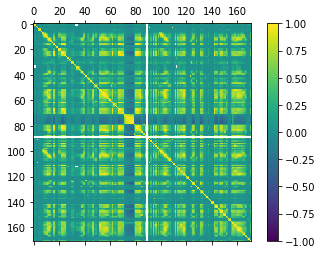

In [28]:
fig = pyplot.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df_train.corr(), vmin=-1, vmax=1)
fig.colorbar(cax)
pyplot.show()

### 3a) Data cleaning - replace Nan with 0 value

In [29]:
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)
print(df_train.head(20))

    aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  ag_001  \
0    76698     0.0  2.130706e+09   280.0     0.0     0.0     0.0     0.0   
1    33058     0.0  0.000000e+00     0.0     0.0     0.0     0.0     0.0   
2    41040     0.0  2.280000e+02   100.0     0.0     0.0     0.0     0.0   
3       12     0.0  7.000000e+01    66.0     0.0    10.0     0.0     0.0   
4    60874     0.0  1.368000e+03   458.0     0.0     0.0     0.0     0.0   
5    38312     0.0  2.130706e+09   218.0     0.0     0.0     0.0     0.0   
6       14     0.0  6.000000e+00     0.0     0.0     0.0     0.0     0.0   
7   102960     0.0  2.130706e+09   116.0     0.0     0.0     0.0     0.0   
8    78696     0.0  0.000000e+00     0.0     0.0     0.0     0.0     0.0   
9   153204     0.0  1.820000e+02     0.0     0.0     0.0     0.0     0.0   
10   39196     0.0  2.040000e+02   170.0     0.0     0.0     0.0     0.0   
11   45912     0.0  0.000000e+00   454.0     0.0     0.0     0.0     0.0   
12    2104  

### 3b) Feature selection - n/a
### 3c) Data transform - n/a

### 3c) Split out training and test datasets 

In [30]:
seedNum = 777
totCol = len(df_train.columns)
array = df_train.values
X_train = array[:,0:totCol-1]
Y_train = array[:,totCol-1]
totCol = len(df_test.columns)
array = df_test.values
X_validation = array[:,0:totCol-1]
Y_validation = array[:,totCol-1]
print("X_train.shape: {} Y_train.shape: {}".format(X_train.shape, Y_train.shape))
print("X_validation.shape: {} Y_validation.shape: {}".format(X_validation.shape, Y_validation.shape))
print ('Total time for data handling and visualization:',(datetime.now() - startTimeScript))

X_train.shape: (60000, 170) Y_train.shape: (60000,)
X_validation.shape: (16000, 170) Y_validation.shape: (16000,)
Total time for data handling and visualization: 0:00:18.090044


### 4) Model and Evaluate Algorithm

#### 4a) Set test options and evaluation metric

In [31]:
num_folds = 10
scoring = 'accuracy'

In [32]:
models = []
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier(random_state=seedNum)))
# models.append(('GBM', GradientBoostingClassifier(random_state=seedNum)))
results = []
names = []
metrics = []

In [33]:
for name, model in models:
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=num_folds, random_state=seedNum, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	metrics.append(cv_results.mean())
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
	print ('Model training time:',(datetime.now() - startTimeModule))
print ('Average metrics ('+scoring+') from all models:',np.mean(metrics))

NB: 0.967333 (0.002400)
Model training time: 0:00:00.976109
RF: 0.993583 (0.000837)
Model training time: 0:09:00.344908
Average metrics (accuracy) from all models: 0.9804583333333333


#### 4a) Set test options and evaluation metric

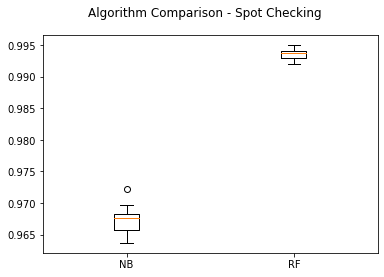

In [34]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

### 5) Improving accuracy

#### 5a) Hyperparameter tuning

In [ ]:
# results = []
# names = []

# startTimeModule = datetime.now()
# paramGrid1 = dict(n_estimators=np.array([75,100,125,150,175]))
# model1 = RandomForestClassifier(random_state=seedNum)
# kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seedNum)
# grid1 = GridSearchCV(estimator=model1, param_grid=paramGrid1, scoring=scoring, cv=kfold)
# grid_result1 = grid1.fit(X_train, Y_train)

# print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
# results.append(grid_result1.cv_results_['mean_test_score'])
# names.append('RF')
# means = grid_result1.cv_results_['mean_test_score']
# stds = grid_result1.cv_results_['std_test_score']
# params = grid_result1.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
# print ('Model training time:',(datetime.now() - startTimeModule))

#### Compare algorithm here if we use more than 1 algorithm for tuning

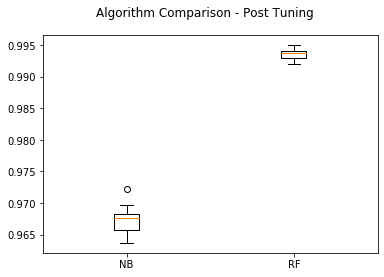

In [35]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

### 6) Finalize model

- Using an optimal model tuned to make predictions on unseen data
- Creating standalone model using the tuned parameters
- Saving an optimal model to file or blob for later use

#### 6a) Prediction for test set

In [36]:
model = RandomForestClassifier(n_estimators=175, random_state=seedNum)
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)
# print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
# print(classification_report(Y_validation, predictions))

[[15605    20]
 [  104   271]]


#### 6b) Create standalone model on entire training dataset

In [37]:
startTimeModule = datetime.now()
finalModel = RandomForestClassifier(n_estimators=175, random_state=seedNum)
finalModel.fit(X_train, Y_train)
print ('Model training time:',(datetime.now() - startTimeModule))

Model training time: 0:01:41.737038


#### 6c) Save model for later use

In [38]:
modelName = 'finalModel_BinaryClass.sav'
dump(finalModel, modelName)

print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:13:19.573983


#### 6d) Challenge metric section

In [44]:
cm = confusion_matrix(Y_validation, predictions).ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['TN', 'FP', 'FN', 'TP'])

total_cost = 10*(cm.FP[0]) + 500*(cm.FN[0])
print(f"Total cost for RF model is {total_cost}")

Total cost for RF model is 52200


In [47]:
print(cm.FP[0], cm.FN[0]*500)

20 52000


In [59]:
from sklearn.preprocessing import MinMaxScaler

X_scaled_train = MinMaxScaler.fit_transform(X_train)
# X_scaled_validation = MinMaxScaler(X_validation)

X_scaled_train.head()

# model = RandomForestClassifier(n_estimators=175, random_state=seedNum)
# model.fit(X_scaled_train, Y_train)
# predictions = model.predict(X_scaled_validation)
# print(predictions)

# cm = confusion_matrix(Y_validation, predictions).ravel()
# cm = pd.DataFrame(cm.reshape((1,4)), columns=['TN', 'FP', 'FN', 'TP'])

# total_cost = 10*(cm.FP[0]) + 500*(cm.FN[0])
# print(f"Total cost for RF model is {total_cost}")

TypeError: fit_transform() missing 1 required positional argument: 'X'

In [61]:
X_train

array([[7.66980000e+04, 0.00000000e+00, 2.13070644e+09, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.30580000e+04, 0.00000000e+00, 0.00000000e+00, ...,
        1.50000000e+03, 0.00000000e+00, 0.00000000e+00],
       [4.10400000e+04, 0.00000000e+00, 2.28000000e+02, ...,
        5.14000000e+02, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.12000000e+02, 0.00000000e+00, 2.13070643e+09, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.02920000e+04, 0.00000000e+00, 2.13070643e+09, ...,
        3.88422000e+05, 0.00000000e+00, 0.00000000e+00],
       [4.02220000e+04, 0.00000000e+00, 6.98000000e+02, ...,
        1.58000000e+02, 0.00000000e+00, 0.00000000e+00]])